In [1]:
import tensorflow as tf

PATCH_SIZE = 7
PATCH_PIXELS = 7*7

BATCH_SIZE = 100

NUM_THREADS = 4

def read(filenames):
    queue = tf.train.string_input_producer(filenames)

    with tf.name_scope('reader'):
        reader = tf.TFRecordReader()
        _, example = reader.read(queue)
    
    with tf.name_scope('features'):
        features = tf.parse_single_example(example, features={
            'us_patch': tf.FixedLenFeature([], tf.string),
            'mr_patch': tf.FixedLenFeature([], tf.string),
        })
    
    with tf.name_scope('features_decode'):
        image = tf.reshape(tf.decode_raw(features['mr_patch'], tf.float64), [PATCH_SIZE, PATCH_SIZE, 1])
        label = tf.reshape(tf.decode_raw(features['us_patch'], tf.float64), [PATCH_SIZE, PATCH_SIZE, 1])
    
    return tf.train.shuffle_batch([image, label],
        batch_size=BATCH_SIZE,
        num_threads=NUM_THREADS,
        capacity=1000 + 3*BATCH_SIZE,
        min_after_dequeue=1000)

In [34]:
image = tf.placeholder(shape=[None, PATCH_SIZE, PATCH_SIZE, 1], dtype=tf.float32)
label = tf.placeholder(shape=[None, PATCH_SIZE, PATCH_SIZE, 1], dtype=tf.float32)

conv1_weight = tf.Variable(tf.truncated_normal(shape=[3, 3, 1, 3]))
conv1_bias = tf.Variable(tf.constant(0.1, shape=[3]))
conv1 = tf.nn.conv2d(image, conv1_weight, strides=[1, 1, 1, 1], padding='SAME') + conv1_bias

conv2_weight = tf.Variable(tf.truncated_normal(shape=[1, 1, 3, 1]))
conv2 = tf.nn.conv2d(conv1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')

cost = tf.nn.l2_loss(label-conv2)
train = tf.train.AdamOptimizer(.01).minimize(cost)

In [27]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def imshow(image):
    plt.imshow(image, cmap=cm.gray, interpolation='none')
    plt.show()

step 0: 4497.10205078125


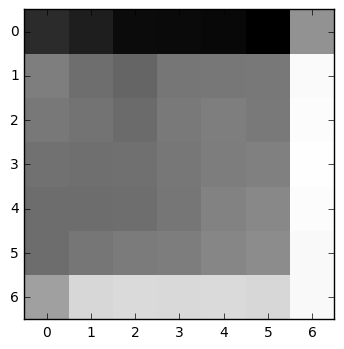

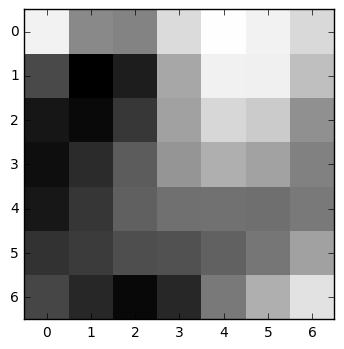

step 500: 8.315643310546875
step 1000: 5.285720348358154
step 1500: 2.89102840423584
step 2000: 3.466599464416504
step 2500: 7.676738739013672
step 3000: 5.494724273681641
step 3500: 2.5167336463928223
step 4000: 2.659899950027466
step 4500: 7.02459716796875
step 5000: 1.0299108028411865


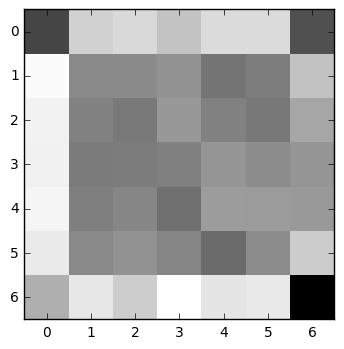

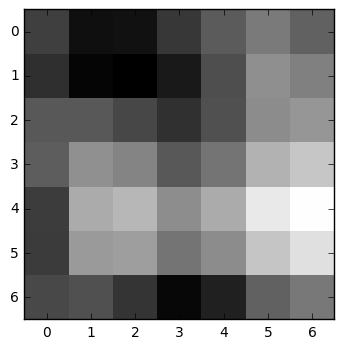

step 5500: 0.40778112411499023
step 6000: 1.5102238655090332
step 6500: 2.7822580337524414
step 7000: 0.1584320068359375
step 7500: 50.08721923828125
step 8000: 5.924199104309082
step 8500: 7.403075218200684
step 9000: 5.087095737457275
step 9500: 1.7360005378723145
step 10000: 3.306302785873413


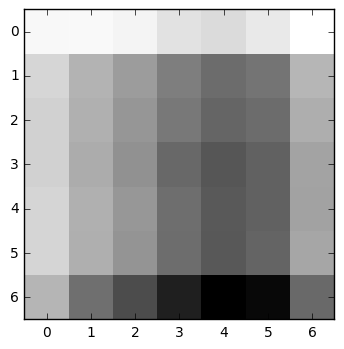

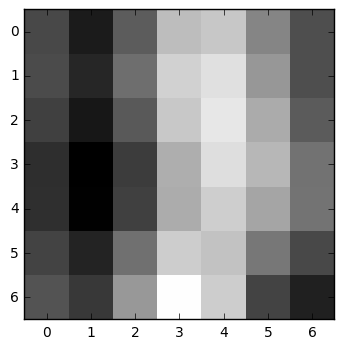

step 10500: 33.02476501464844
step 11000: 40.220577239990234
step 11500: 23.55337142944336
step 12000: 21.47491455078125
step 12500: 2.102781057357788
step 13000: 15.767045974731445
step 13500: 33.09946823120117
step 14000: 22.047435760498047
step 14500: 25.606231689453125
step 15000: 3.0596680641174316


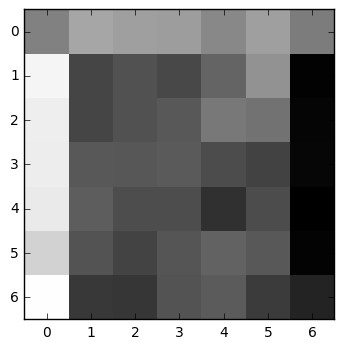

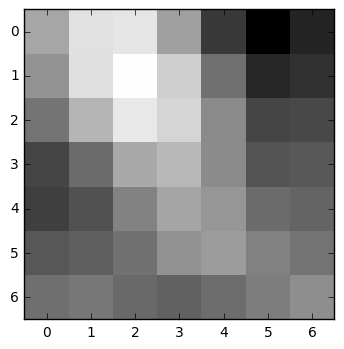

step 15500: 0.5998371839523315
step 16000: 0.3733425736427307
step 16500: 0.23789018392562866
step 17000: 45.141510009765625
step 17500: 15.945143699645996
step 18000: 1.3437178134918213
step 18500: 6.832705497741699
step 19000: 4.849581718444824
step 19500: 3.60849666595459
step 20000: 2.78251051902771


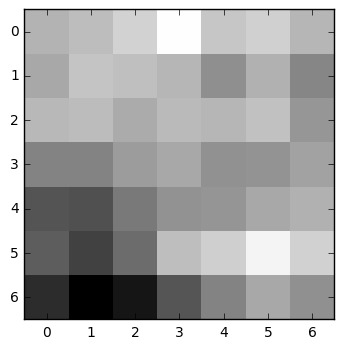

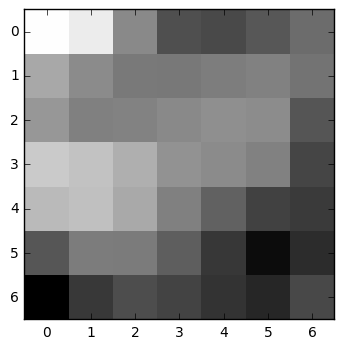

step 20500: 6.739908218383789
step 21000: 3.7125980854034424
step 21500: 6.081027507781982
step 22000: 6.415688514709473
step 22500: 2.0721824169158936
step 23000: 6.7313761711120605
step 23500: 3.947253465652466
step 24000: 1.9290872812271118
step 24500: 6.038976669311523
step 25000: 3.723384380340576


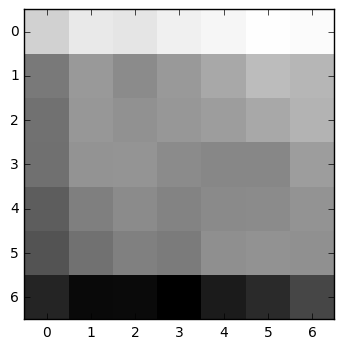

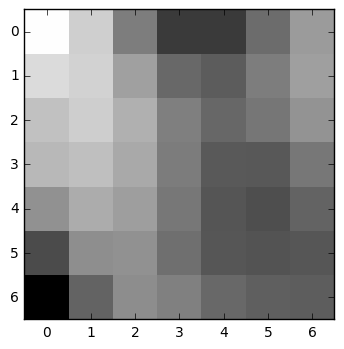

step 25500: 3.1087753772735596
step 26000: 4.654933452606201
step 26500: 1.9372689723968506
step 27000: 0.30543383955955505
step 27500: 1.3446686267852783
step 28000: 2.428724765777588
step 28500: 0.20109595358371735
step 29000: 3.744075059890747
step 29500: 4.995781898498535
step 30000: 3.24112868309021


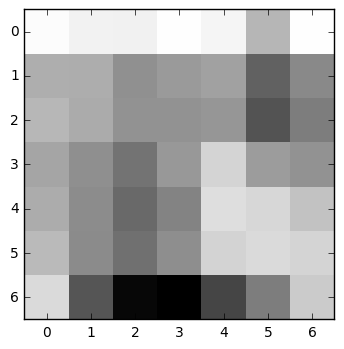

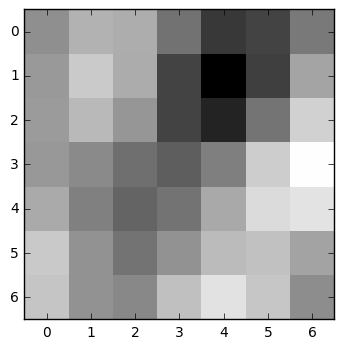

step 30500: 4.488409996032715
step 31000: 1.54811429977417
step 31500: 5.398012638092041
step 32000: 36.61777877807617
step 32500: 31.927888870239258
step 33000: 19.087982177734375


In [ ]:
test_files = ['th-30/{:02}.tfrecord'.format(i) for i in range(1, 8)]
train_files = ['th-30/{:02}.tfrecord'.format(i) for i in range(8, 15)]

batch = read(train_files)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        step = 0
        
        while not coord.should_stop():
            images, labels = sess.run(batch)
            
            _, norm, results = sess.run([train, cost, conv2], feed_dict={
                image: images,
                label: labels,
            })
        
            if step % 500 == 0:        
                print('step {}: {}'.format(step, norm))
            if step % 5000 == 0:
                imshow(results[0, :, :, 0])
                imshow(labels[0, :, :, 0])
            
            step += 1
    except tf.errors.OutOfRangeError:
        print('done with training')
    finally:
        coord.request_stop()
        coord.join(threads)